Data from: https://github.com/ravsimar-sodhi/jibes-and-delights

In [20]:
import string
import os
import signal
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pickle

interrupt = [False]

def sig_handler(signum, frame):
    interrupt[0] = True
    

In [3]:
files = ['insults.txt']

text = []
for f in files:
    with open(f, 'r') as iofile:
        text += iofile.readlines()

In [4]:
text = [line.lower() for line in text]
print(len(text))
print(text[0])

68159
during inclement weather does your hair function as a umbrella?



In [5]:
print(min([len(line) for line in text]))

17


In [6]:
tokens = sorted(set(''.join(text)))
print(tokens)

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '£', '©', '®', '°', '´', 'â', 'ä', 'æ', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'ñ', 'ö', 'ü', 'ʖ', '͜', '͠', '͡', 'ε', 'π', 'б', 'е', 'ж', 'й', 'м', 'о', 'ل', '–', '—', '‘', '’', '“', '”', '…', '™', '★', '☑', '♥', '♪', '✄', '✅', '✓', '✔', '⬇', '️', '￼', '🌚', '🍄', '🎳', '🏇', '👏', '💕', '💩', '😂', '😃', '😈', '😜']


In [7]:
class RecurrentNeuralNetwork(nn.Module):
    def __init__(self, tokens, embedding_size=16, hidden_dim_size=64, num_layers=1):
        super(self.__class__,self).__init__()
        self.tokens = tokens
        self.token_to_id = dict([(y, x) for (x, y) in enumerate(self.tokens, 0)])
        self.id_to_token = dict(enumerate(self.tokens, 0))
        
        self.embedding = nn.Embedding(len(self.tokens), embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_dim_size, num_layers=num_layers, batch_first=True)
        self.rnn_to_logits = nn.Linear(hidden_dim_size, len(self.tokens))
    
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.embedding(x))
        next_logits = self.rnn_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [16]:
class TextDataset(torch.utils.data.IterableDataset):
    def __init__(self, text, seq_length, step=1):
        self.tokens = sorted(set(''.join(text)))
        self.token_to_id = dict([(y, x) for (x, y) in enumerate(self.tokens, 0)])
        self.text = [self.token_to_id[char] for char in text]
        self.seq_length = seq_length
        self.step =step
    
    def __iter__(self):
        self.idx = -self.step
        return self
    
    def __next__(self):
        self.idx += self.step
        if self.idx <= len(self.text) - seq_length:
            return self.text[self.idx : self.idx + seq_length]
        else:
            raise StopIteration

seq_length = 16
step = 16

In [28]:
def save_state(model, other):
    torch.save(model.state_dict(), 'lstm')
    with open('other', 'wb') as f:
        pickle.dump(other, f)

In [30]:
def load_state():
    model = RecurrentNeuralNetwork(tokens, 50, 250, 4)
    model.load_state_dict(torch.load('lstm'))
    with open('other', 'rb') as f:
        other = pickle.load(f)
    return model, other

In [47]:
model = RecurrentNeuralNetwork(tokens, 50, 250, 4)

In [48]:
data_loader = torch.utils.data.DataLoader(TextDataset(''.join(text), seq_length, step), batch_size=64)

In [49]:
history_model = []
local_history = []
local_history_length = None

In [52]:
model, [data_loader, history_model, local_history, local_history_length] = load_state()

In [50]:
opt = torch.optim.Adam(model.parameters())
loss = nn.NLLLoss()

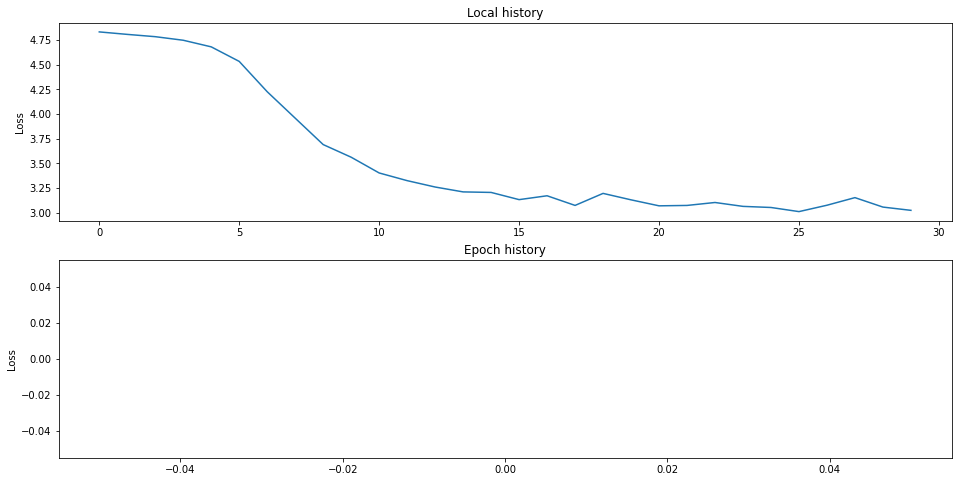

Done


In [53]:
interrupt = [False]
signal.signal(signal.SIGINT, sig_handler)
while not interrupt[0]:
    for data in data_loader:
        
        ### TRAIN BLOCK ###
        
        opt.zero_grad()
        batch_ix = torch.stack(data).transpose(0, 1)

        logp_seq = model(batch_ix)

        predictions_logp = logp_seq[:, :-1].reshape(-1, len(tokens))
        actual_next_tokens = batch_ix[:, 1:].reshape(-1)

        loss_res = loss(predictions_logp, actual_next_tokens)

        loss_res.backward()
        opt.step()
        
        local_history.append(loss_res.data)
        
        
        ### DISPLAY BLOCK ###
        
        clear_output(True)
        fig, axs = plt.subplots(2, figsize=(16, 8))
        axs[0].plot(local_history)
        axs[1].plot(history_model)
        if local_history_length is not None:
            axs[0].set_xlim(local_history_length)
        axs[0].set_ylabel('Loss')
        axs[1].set_ylabel('Loss')
        axs[0].set_title('Local history')
        axs[1].set_title('Epoch history')
        plt.show()
        
        ### SAVE AND INTERRUPT BLOCK ###
        
        save_state(model, [data_loader, history_model, local_history, local_history_length])
        if interrupt[0]:
            break
    
    if not interrupt[0]:
        local_history_length = len(local_history)
        local_history = []
        history_model.append(loss_res.data)
print('Done')